# Effective Spread

### Mauricio Martínez Ulloa

Using Roll's model for effective spreads, do the following using the `aapl_5m_train.csv` dataset:

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygments.lexers.ruby import FancyLexer

Determine the effective spread using the block method `cov([dt1, dt2, dt3], [dt4, dt5, dt6])`m

In [19]:
df = pd.read_csv('data/aapl_5m_train.csv')
df = df[['Open', 'High', 'Low', 'Close']]
df.dropna(inplace=True)

In [20]:
'Columna Rt_1,2,3,4... sería igual a Dt_1,2,3,4...'
df['rt'] = df.Close.pct_change()
df.dropna(inplace=True)

In [21]:
def block_method(df):

    rt = df['rt']

    block1 = []
    block2 = []
    cov_bloques = []
    spreads = []
    bloque = 3

    for i in range(0, len(rt) - 2*bloque, bloque):
        block1 = rt[i:i + bloque]
        block2 = rt[i + bloque: i + 2*bloque]

        cov_bloque = np.cov(block1, block2)[0,1]
        cov_bloques.append(cov_bloque)

        if cov_bloque < 0:
            spread = 2 * np.sqrt(-cov_bloque)
        else:
            spread = np.nan
        spreads.append(spread)

    return spreads


array([[<Axes: title={'center': 'spreads'}>]], dtype=object)

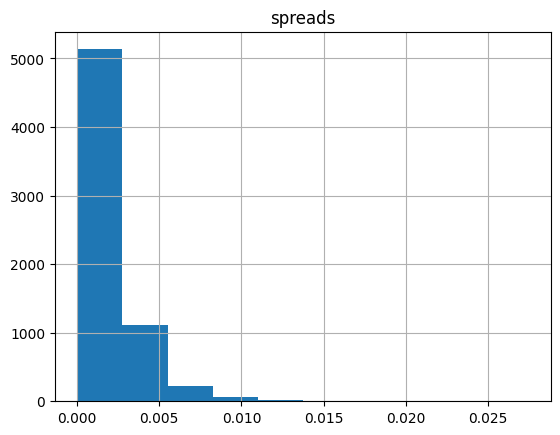

In [22]:
spreads_block = block_method(df)
spreads_block_df = pd.DataFrame()
spreads_block_df['spreads'] = spreads_block
spreads_block_df.hist()

In [23]:
mean_block_spread = spreads_block_df.spreads.mean()

- Determine the effective spread using the serial covariance `cov([dt1, dt2, dt3], [dt2, dt3, dt4])`

In [24]:
def serial_method(df):

    rt = df['rt']
    bloque = 3
    spreads = [np.nan] * (2 * bloque)
    covs = []


    for i in range(1, len(rt)):
        x = rt[i-1 : i+2]
        y = rt[i : i+3]

        if len(x) == len(y) and len(x) > 1:
            cov_serial = np.cov(x,y)[0,1]
            covs.append(cov_serial)

            if cov_serial < 0:
                spread = 2 * np.sqrt(-cov_serial)
            else:
                spread = np.nan
            spreads.append(spread)

    return spreads


array([[<Axes: title={'center': 'spreads'}>]], dtype=object)

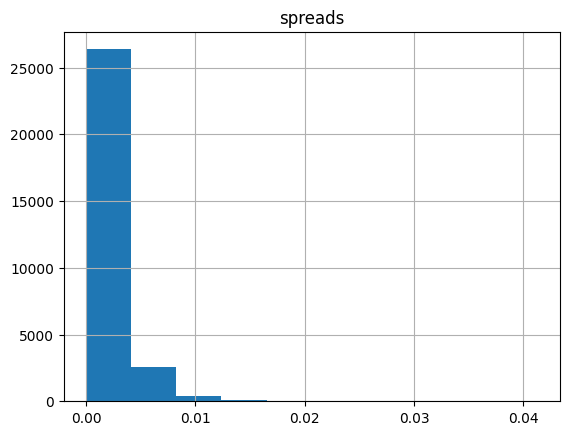

In [25]:
spreads_serial = serial_method(df)
spreads_serial_df = pd.DataFrame()
spreads_serial_df['spreads'] = spreads_serial
spreads_serial_df.hist()

In [26]:
mean_spread_serial = spreads_serial_df['spreads'].mean()

b- Infer the last operation type

In [27]:
def bid_o_ask(df):

    rt = df['rt'].values

    BoA = []

    for i in range(1, len(rt)):
        if rt[i] > 0:
            BoA.append("Ask")
        else:
            BoA.append("Bid")
    return BoA

In [28]:
len(spreads_block)

13190

In [29]:
df['Type'] = ["NaN"] + bid_o_ask(df)
df['Spread_Serial'] = spreads_serial[:39574]


s*- Calculate the Bid & Ask price using a window size of [5, 10, 20, 50, 100]

In [30]:
def effective_spread_bid_ask(df, window_size=3, window_step=3):

    # Price Delta
    df = df.copy()
    df['Price Delta'] = df['Close'].diff()

    # Tipo de operación
    op_type = []
    for i in range(len(df)-1):
        delta_i = df.iloc[i+1]["Price Delta"]
        if delta_i > 0:
            op_type_i = "Ask"
        elif delta_i == 0:
            op_type_i = "None"
        else:
            op_type_i = "Bid"
        op_type.append(op_type_i)
    op_type.append("NaN")  # último elemento
    df["Last Operation"] = op_type

    # Calcular spread
    spread = []
    for i in range(len(df) - window_step - window_size):
        block1 = df.iloc[i:i+window_size]["Price Delta"]
        block2 = df.iloc[i+window_step:i+window_step+window_size]["Price Delta"]
        block_covariance = np.cov(block1, block2)[0,1]
        spread_i = 2 * np.sqrt(abs(block_covariance)) if block_covariance < 0 else 0
        spread.append(spread_i)

    # Rellenar con NaN para dimensiones
    filler_length = len(df) - len(spread)
    spread += [np.nan] * filler_length
    df["Quote"] = spread

    # Calcular Bid y Ask
    bid_list = []
    ask_list = []
    for i in range(len(df)):
        if np.isnan(df.iloc[i]["Quote"]):
            bid_list.append(np.nan)
            ask_list.append(np.nan)
        else:
            bid_list.append(df.iloc[i]["Close"] - df.iloc[i]["Quote"]/2)
            ask_list.append(df.iloc[i]["Close"] + df.iloc[i]["Quote"]/2)

    df["Bid"] = bid_list
    df["Ask"] = ask_list

    # Promedio del spread
    spread_prom = np.nanmean(spread)

    return spread_prom, df

In [31]:
spread_prom, df = effective_spread_bid_ask(df, window_size=3, window_step=3)
df.head()

,Open,High,Low,Close,rt,Type,Spread_Serial,Price Delta,Last Operation,Quote,Bid,Ask
1,132.75,132.750000,131.809997,131.889999,-0.006927,NaN,NaN,NaN,Ask,0.000000,131.889999,131.889999
2,131.50,132.339996,131.500000,132.059997,0.001289,Ask,NaN,0.169998,Ask,0.000000,132.059997,132.059997
3,132.00,132.250000,131.899993,132.250000,0.001439,Ask,NaN,0.190003,Bid,0.284793,132.107604,132.392396
4,132.00,132.018096,131.520004,131.589996,-0.004991,Bid,NaN,-0.660004,Bid,0.000000,131.589996,131.589996
5,132.00,132.089996,131.300003,131.448898,-0.001072,Bid,NaN,-0.141098,Bid,0.374782,131.261507,131.636289


- Find the average spread of AAPL and analyze the spreads of all methods to find which one fits best for this time series

In [37]:
mean_block = np.nanmean(spreads_block)
mean_serial = np.nanmean(spreads_serial)
mean_bidask = np.nanmean(df['Quote'])

print('SPREADS:','\n','Mean de block:',mean_block,'\n','Mean de serial:',mean_serial,'\n','Mean de Bid/Ask:',mean_bidask)

SPREADS: 
 Mean de block: 0.0020130570215468493 
 Mean de serial: 0.0021633866464770717 
 Mean de Bid/Ask: 0.1499073290431435


- Upload a jupyter notebook with the results